# Cliff Walking Q-Learning v SARSA 
SARSA on-policy control v q-learning off-policy control

Comparison of methods as per the example in the Sutton Barto Text.

Objects to create:
- environment to simulate the 'cliff walk'
- entity to simulate the traversal thru the paths
    

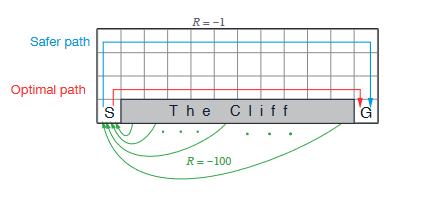

The blue line represents the expected SARSA path and the red is the expected Q-learning path.

In [1]:
import numpy as np

In [2]:
#define environment object
class environment():
    def __init__(self, dims = [4,10], start = [3,0] , terminal = [3,9], reward = -1, the_cliff_reward = -100, the_cliff = [(3,1),(3,2),(3,3),(3,4),(3,5),(3,6),(3,7),(3,8)]):
        """
        this class initializes the environment
        
        inputs
        dims - a scalar to define a dxd grid environment
        terminals - a list of lists of ordered pairs representing the location in the grid of the terminal states
        reward -  the reward value for moving one space (unless in a terminal state)
        
        self defined variables
        actions - determines actions that can be taken in the environment where 0 = left, 1 = up, 2 = right, 3 = down
        
        returns
        None
        
        cheating here as i did not do checks on things for integrity...
        """
        self.dims = dims
        self.start = start
        self.terminal = terminal
        self.reward = reward
        self.the_cliff_reward = the_cliff_reward
        self.the_cliff = the_cliff
        self.actions = [np.array([0, -1]),
                       np.array([-1, 0]),
                       np.array([0, 1]),
                       np.array([1, 0])]
            
    def is_terminal(self,i,j):
        """
        This function checks if coordinates are for a terminal state
        
        inputs
        i = y coord (row)
        j = x coord (col)
        
        returns
        boolean on terminal status
        """
        #print("episode end")
        return [i,j] == self.terminal
        
        
    def next_state(self,i,j,a):
        """
        this function determines the next state and the reward received
        This function also checks if current state is terminal, or next state is terminal
        This function will also bounce back to the original coordinates if it is an edge/border square in the grid
        
        inputs
        i = y coord (row)
        j = x coord (col)
        a = action taken where 0 = left, 1 = up, 2 = right, 3 = down
        
        returns
        i_next, j_next representing next state coordinates
        reward received for moving
        """
        # check if current state is terminal, if so return current state and reward = 0
        #i = row, j = col
        if self.is_terminal(i,j):
            return i, j, 0
        
        # get next state
        next = [i,j] + self.actions[a] 
        #print(next)
        
        #check if move takes off grid on top or left go back to original space
        if next[0] < 0 or next[1] < 0:
            return i, j, self.reward
        #check if next is the cliff go back to start
        elif (next[0], next[1]) in self.the_cliff:
            return self.start[0], self.start[1], self.the_cliff_reward
        #check if off bottom, or right go back to original space
        elif (next[0] > (self.dims[0]-1)) or (next[1] > (self.dims[1]-1)):
            return i, j, self.reward 
        else:
            return next[0], next[1], self.reward 



In [3]:
class sarsa_entity():
    def __init__(self, state_action_values, environment, algo_param_alpha = 1, gamma = 0.8, epsilon = 0.05, start = [3,0]):
        """
        This class initializes the entity which will 
        walk thru the grid world and collect data
        this follows a puerly greedy policy atm
        
        inputs
        rand_policy = policy ot follow if not initialized
        state_action_values - calculated state-action values for all states except the terminal state
        algo_param_alpha - step size to be used
        
        """
        
        self.state_action_values = state_action_values
        self.algo_param_alpha = algo_param_alpha
        self.gamma = gamma
        self.environment = environment
        self.start_location = start
        self.current_location = start
        self.epsilon = epsilon

                
    def pick_action(self, state_action_values):
        #need to fix this asap
        
        #simple pick action based in random policy to go any direction with equal probability
        greedy_action = np.argmax(state_action_values)
        #print(greedy_action)
        
        action = greedy_action
        
        if self.epsilon == 0:
            return action
        
        if np.random.binomial(1, self.epsilon, 1):
            temp_list = [0,1,2,3]
            #print(temp_list)
            temp_list.pop(greedy_action)
            #print(temp_list)
            action = np.random.choice(temp_list)
            #print(action)
        
        return action
    
    def take_action(self, action):
        next_i, next_j, reward = self.environment.next_state(self.current_location[0], self.current_location[1], action)
        return next_i, next_j, reward
    
    def restart_walk(self):
        self.current_location = self.start_location
    
    def take_a_walk(self):
        
        self.restart_walk()
        
        terminal = False
        
        #choose first action according to e-greedy
        i, j = self.current_location[0], self.current_location[1]
        state_action_values = self.state_action_values[(i,j)]
        action = self.pick_action(state_action_values)
        next_i, next_j, reward = self.take_action(action)
        
        while not terminal:

            state_action_values = self.state_action_values[(next_i, next_j)]
            next_action = self.pick_action(state_action_values)
            next_action_value = state_action_values[next_action]
            
            #update last state value
            self.state_action_values[(i,j)][action] = \
            (self.state_action_values[(i,j)][action] + \
            (self.algo_param_alpha * \
            (reward + \
            (self.gamma * next_action_value) - \
            self.state_action_values[(i,j)][action])))
             
            #update location
            self.current_location = [next_i, next_j] 
            i, j = next_i, next_j
            
            #update to iterate 
            action = next_action
            next_i, next_j, reward = self.take_action(action)
            
            
            if reward == 0:
                terminal = True
                
    def policy_walk(self):
        self.restart_walk()
        
        terminal = False
        
        action_dict = {0 : "left", 1 : "up", 2 : "right", 3 : "down"}
        
        number_of_steps = 0
        
        orig_epsilon = self.epsilon
        
        self.epsilon = 0
        
        while not terminal:
            print("current state is:", self.current_location)
            print("current step is:", number_of_steps)
            state_action_values = self.state_action_values[(self.current_location[0],self.current_location[1])]
            
            action = self.pick_action(state_action_values)
            print("next action is:", action_dict[action])
            
            next_i, next_j, reward = self.take_action(action)
            
            #update location
            self.current_location = [next_i, next_j] 
            
            number_of_steps = number_of_steps + 1
            
            if number_of_steps > 100:
                print("walk failure")
                reward = 0
            
            if reward == 0:
                print("you have reached the terminal state in ", number_of_steps, " steps!")
                self.epsilon = orig_epsilon                      
                terminal = True          
                
    def give_state_action_values(self):
        return self.state_action_values
    

In [4]:
class q_entity():
    def __init__(self, state_action_values, environment, algo_param_alpha = 0.25, gamma = 0.5, epsilon = 0.05, start = [3,0]):
        """
        This class initializes the entity which will 
        walk thru the grid world and collect data
        this follows a puerly greedy policy atm
        
        inputs
        rand_policy = policy ot follow if not initialized
        state_action_values - calculated state-action values for all states except the terminal state
        algo_param_alpha - step size to be used
        
        """
        
        self.state_action_values = state_action_values
        self.algo_param_alpha = algo_param_alpha
        self.gamma = gamma
        self.environment = environment
        self.start_location = start
        self.current_location = start
        self.epsilon = epsilon
        self.orig_epslion = epsilon

                
    def pick_action(self, state_action_values):
        #need to fix this asap
        
        #simple pick action based in random policy to go any direction with equal probability
        greedy_action = np.argmax(state_action_values)
        #print(greedy_action)
        
        action = greedy_action
        
        if self.epsilon == 0:
            return action
        
        if np.random.binomial(1, self.epsilon, 1):
            temp_list = [0,1,2,3]
            #print(temp_list)
            temp_list.pop(greedy_action)
            #print(temp_list)
            action = np.random.choice(temp_list)
            #print(action)
        
        return action
    
    def take_action(self, action):
        next_i, next_j, reward = self.environment.next_state(self.current_location[0], self.current_location[1], action)
        return next_i, next_j, reward
    
    def restart_walk(self):
        self.current_location = self.start_location
    
    def take_a_walk(self):
        
        self.restart_walk()
        
        terminal = False
               
        while not terminal:
            #choose actual action being taken according to e-greedy
            i, j = self.current_location[0], self.current_location[1]
            state_action_values = self.state_action_values[(i,j)]
            action = self.pick_action(state_action_values)
            next_i, next_j, reward = self.take_action(action)

            state_action_values = self.state_action_values[(next_i, next_j)]
            
            #flip epsilon to 0 and pick next action as a greedy choice
            self.epsilon = 0
            next_action = self.pick_action(state_action_values)
            self.epsilon = self.orig_epslion
            
            next_action_value = state_action_values[next_action]
            
            #update last state value
            self.state_action_values[(i,j)][action] = \
            (self.state_action_values[(i,j)][action] + \
            (self.algo_param_alpha * \
            (reward + \
            (self.gamma * next_action_value) - \
            self.state_action_values[(i,j)][action])))
             
            #update location
            self.current_location = [next_i, next_j]          
            
            if reward == 0:
                terminal = True
                
    def policy_walk(self):
        self.restart_walk()
        
        terminal = False
        
        action_dict = {0 : "left", 1 : "up", 2 : "right", 3 : "down"}
        
        number_of_steps = 0
        
        orig_epsilon = self.epsilon
        
        self.epsilon = 0
        
        while not terminal:
            print("current state is:", self.current_location)
            print("current step is:", number_of_steps)
            state_action_values = self.state_action_values[(self.current_location[0],self.current_location[1])]
            
            action = self.pick_action(state_action_values)
            print("next action is:", action_dict[action])
            
            next_i, next_j, reward = self.take_action(action)
            
            #update location
            self.current_location = [next_i, next_j] 
            
            number_of_steps = number_of_steps + 1
            
            if number_of_steps > 100:
                print("walk failure")
                reward = 0
            
            if reward == 0:
                print("you have reached the terminal state in ", number_of_steps, " steps!")
                self.epsilon = orig_epsilon                      
                terminal = True          
                
    def give_state_action_values(self):
        return self.state_action_values
    

In [5]:
#step size
algo_param_alpha = 0.25

In [6]:
#dimensions
dims = [4,10]

In [7]:
#arbitrary state_action_values
#using a dict because look up is much easier then
state_action_values1 = {(None,None,None):0}

for i in range(dims[0]):
    for j in range(dims[1]):
        state_action_values1[(i,j)] = [0,0,0,0]
        
state_action_values1.pop((None,None,None))
            
#state_action_values

0

In [8]:
environment1 = environment()
entity1 = sarsa_entity(state_action_values1, environment1)

In [9]:
number_of_episodes = 1000

for episode in range(number_of_episodes):
    #if episode%10 == 0:
    #print("episode #:", episode)
    entity1.take_a_walk()
    
state_action_values1 = entity1.give_state_action_values()

policy = np.zeros((dims[0],dims[1],4))

for key in state_action_values1:
    i =  key[0]
    j = key[1]
    policy[i,j] = state_action_values1[key]
    


In [10]:
state_action_values1

{(0, 0): [-21.60926961542814,
  -18.26866560606853,
  -4.999999943460896,
  -18.287555072000007],
 (0, 1): [-4.976388167585652,
  -5.191493849826956,
  -7.864966787939983,
  -45.53151053406853],
 (0, 2): [-5.028964776920135,
  -37.39420313981574,
  -25.742915334068527,
  -4.824078139555841],
 (0, 3): [-10.437630797334064,
  -9.354362367851456,
  -4.997971759039636,
  -55.67288842725483],
 (0, 4): [-4.999999999999485,
  -4.996038591874289,
  -4.161139200000001,
  -37.410805209482064],
 (0, 5): [-4.999888496274009,
  -4.993810299803575,
  -3.9514240000000007,
  -4.99999042190287],
 (0, 6): [-4.999782219285171,
  -7.782640861309784,
  -3.6892800000000006,
  -4.4631290880000005],
 (0, 7): [-4.987910741803855,
  -4.990328593443085,
  -3.3616000000000006,
  -4.976388167585652],
 (0, 8): [-4.9704852094820655,
  -4.953883139815727,
  -4.9704852094820655,
  -2.9520000000000004],
 (0, 9): [-4.887410009315738,
  -2.9520000000000004,
  -4.780097674444801,
  -2.4400000000000004],
 (1, 0): [-4.99746

In [11]:
#optimal steps for this problem is 15, book notes 17 is the average on their solution
#this method sets epsilon to 0 and uses the q values to do a pure exploitation.
print("doing policy walk")
entity1.policy_walk()

doing policy walk
current state is: [3, 0]
current step is: 0
next action is: up
current state is: [2, 0]
current step is: 1
next action is: right
current state is: [2, 1]
current step is: 2
next action is: up
current state is: [1, 1]
current step is: 3
next action is: right
current state is: [1, 2]
current step is: 4
next action is: right
current state is: [1, 3]
current step is: 5
next action is: right
current state is: [1, 4]
current step is: 6
next action is: up
current state is: [0, 4]
current step is: 7
next action is: right
current state is: [0, 5]
current step is: 8
next action is: right
current state is: [0, 6]
current step is: 9
next action is: right
current state is: [0, 7]
current step is: 10
next action is: right
current state is: [0, 8]
current step is: 11
next action is: down
current state is: [1, 8]
current step is: 12
next action is: right
current state is: [1, 9]
current step is: 13
next action is: down
current state is: [2, 9]
current step is: 14
next action is: down

In [12]:
#arbitrary state_action_values
#using a dict because look up is much easier then
state_action_values2 = {(None,None,None):0}

for i in range(dims[0]):
    for j in range(dims[1]):
        state_action_values2[(i,j)] = [0,0,0,0]
        
state_action_values2.pop((None,None,None))
            
#state_action_values

0

In [13]:
environment2 = environment()
entity2 = q_entity(state_action_values2, environment1)

In [14]:
number_of_episodes = 1000

for episode in range(number_of_episodes):
    #if episode%100 == 0:
        #print("episode #:", episode)
    entity2.take_a_walk()
    
state_action_values2 = entity2.give_state_action_values()

policy = np.zeros((dims[0],dims[1],4))

for key in state_action_values2:
    i =  key[0]
    j = key[1]
    policy[i,j] = state_action_values2[key]
    


In [15]:
state_action_values2

{(0, 0): [-1.9982408443666682,
  -1.9982804385274122,
  -1.9981193548532306,
  -1.9983997310623263],
 (0, 1): [-1.997479450665053,
  -1.9974524612537783,
  -1.9972541496998262,
  -1.9975737085723215],
 (0, 2): [-1.996553971956633,
  -1.9957006734299683,
  -1.995468221859371,
  -1.9954689174980909],
 (0, 3): [-1.9932354080587757,
  -1.9925916617531823,
  -1.992029356991292,
  -1.992061136519233],
 (0, 4): [-1.987545694011522,
  -1.9871289304854725,
  -1.9863323252991836,
  -1.987100548057465],
 (0, 5): [-1.979171725202673,
  -1.9751982396639427,
  -1.9751914003202544,
  -1.9764574717759242],
 (0, 6): [-1.9613716709883884,
  -1.958383693508491,
  -1.9543592586721639,
  -1.9576328442210083],
 (0, 7): [-1.9216218707970107,
  -1.9188621924725555,
  -1.919354347111249,
  -1.9187669275432864],
 (0, 8): [-1.8650181452013181,
  -1.8748903681667772,
  -1.8555281329901547,
  -1.8583783868777959],
 (0, 9): [-1.7598674067967188,
  -1.7602389829542062,
  -1.7575419998162065,
  -1.742783617302872],
 

In [16]:
#optimal steps for this problem is 15, book notes 17 is the average on their solution
#this method sets epsilon to 0 and uses the q values to do a pure exploitation.
print("doing policy walk")
entity2.policy_walk()

doing policy walk
current state is: [3, 0]
current step is: 0
next action is: up
current state is: [2, 0]
current step is: 1
next action is: right
current state is: [2, 1]
current step is: 2
next action is: right
current state is: [2, 2]
current step is: 3
next action is: right
current state is: [2, 3]
current step is: 4
next action is: right
current state is: [2, 4]
current step is: 5
next action is: right
current state is: [2, 5]
current step is: 6
next action is: right
current state is: [2, 6]
current step is: 7
next action is: right
current state is: [2, 7]
current step is: 8
next action is: right
current state is: [2, 8]
current step is: 9
next action is: right
current state is: [2, 9]
current step is: 10
next action is: down
current state is: [3, 9]
current step is: 11
next action is: left
you have reached the terminal state in  12  steps!


# Findings
SARSA takes 16 steps because it goes to the upper edge of the grid to avoid the cliff while q takes 12 steps because it goes and walks along the cliff.